In [18]:
%matplotlib inline
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Embedding, Input,Convolution1D, MaxPooling1D,Flatten,Dropout,GlobalMaxPool1D,Bidirectional,LSTM
from keras.models import Sequential 
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
import numpy as np # linear algebra

## Gather data

In [19]:
# Load listings.csv data from Boston
lis_bos = pd.read_csv('dat/boston/listings.csv')
# Load reviews.csv data from reviews
rev_bos = pd.read_csv('dat/boston/reviews.csv')

## Assess

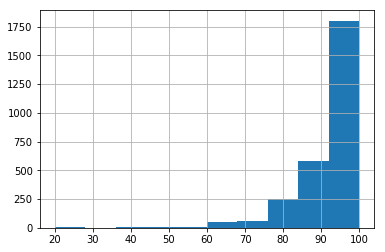

In [20]:
# Plotting histogram of review_scores_rating's column
lis_bos['review_scores_rating'].hist();

In [21]:
# Displaying the first 5 data in reviews.csv
rev_bos.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [5]:
#  Getting info from listings.csv
lis_bos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

## Clean

In [22]:
def clean(rev_bos, lis_bos):
     """
    INPUT:
    rev_bos -review data from reviews.csv
    lis_bos- listings data from listings.csv
    
    OUTPUT:
    X and y that has the following characteristics:
    -Drop the id column
    -  rename listing_id to id for merging purpose
    - Getting the id and review_scores_rating column
    - Filling missing values with '?' because the user might rate but not comment
    - Droping review_scores_rating rows with missing values for accurate data purposes
    - Getting training data
    - Getting Label data
    - converting data to positive review(1 for review greater than 80%) and negative review(0 for review less than 80%)
    """
    # Drop the id column
    rev_bos.drop('id', axis=1, inplace = True)
    # rename listing_id to id for merging purpose
    rev_bos.rename(index=str, columns = {'listing_id':'id'}, inplace = True)
    # Getting the id and review_scores_rating column
    df = lis_bos[['id', 'review_scores_rating']]
    
    df1 = rev_bos.merge(df, on = 'id')
    # Filling missing values with '?' because the user might rate but not comment
    df1.comments.fillna('?', inplace=True)
    # Droping review_scores_rating rows with missing values for accurate data purposes
    df1.dropna(subset=['review_scores_rating'], inplace = True)
    
    # Getting training data
    X = df1['comments'].values
    # Getting Label data
    y = df1['review_scores_rating'].values
    
    # converting data to positive review(1 for review greater than 80%) and negative review(0 for review less than 80%)
    new_y=[]
    for i in y:
        if i >=80.0:
            i =1
            new_y.append(i)
        else:
            i=0
            new_y.append(i)
    y=new_y
    return X, y

In [23]:
X,y = clean(rev_bos, lis_bos)

## Model

In [18]:
max_features = 20000
maxlen = 100

In [19]:
# Tokenizing the training data
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
# converting to sequence
list_tokenized_train = tokenizer.texts_to_sequences(X)
# Padding the sequence
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)


In [ ]:
def get_model():
    """
    Building LSTM model for training
    """
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


model = get_model()
batch_size = 32
epochs = 2


file_path="weights_base2.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [checkpoint, early] #early
history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)


Train on 61447 samples, validate on 6828 samples
Epoch 1/2
61447/61447 [==============================] - 527s - loss: 0.1289 - acc: 0.9641 - val_loss: 0.1498 - val_acc: 0.9625
Epoch 2/2
19488/61447 [========>.....................] - ETA: 344s - loss: 0.0941 - acc: 0.9671

## Visualize

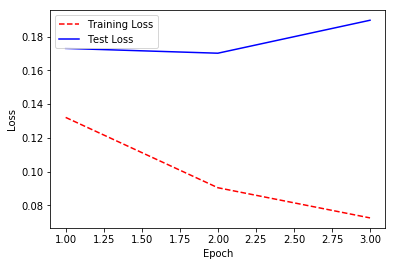

In [24]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

From observations, the model is overfitting.Possible suggestions are:
- incease the training data(especially negative reviews)
- Use a less complex model